In [1]:
import os.path as osp
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

import fish_models

# Data

In [2]:
raycast = fish_models.Raycast(
            n_fish_bins=50,
            n_wall_raycasts=50,
            fov_angle_fish_bins=2*np.pi,
            fov_angle_wall_raycasts=2*np.pi,
            world_bounds=([-50, -50], [50, 50]),
            view_of = ["fish", "fish_oris", "walls"]
        )

In [3]:
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\train"

dset = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)

Loading data from 197 files.


100%|████████████████████████████████████████| 197/197 [00:06<00:00, 29.96it/s]


Calculating views from 197 files.


100%|████████████████████████████████████████| 197/197 [01:24<00:00,  2.33it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 24588.68it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 24517.18it/s]


Reducing shape of views.


100%|██████████████████████████████████████| 197/197 [00:00<00:00, 1497.35it/s]


Status of IoDataset:
poses	(197, 8, 749, 3):	consisting of x, y, orientation.
actions	(197, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(197, 8, 749, 150):	consisting of 50 fish bins, 50 fish oris and 50 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them


In [4]:
more_than_2_mask = (~np.isnan(dset["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) >= 2
more_than_2_mask.shape, more_than_2_mask.sum()

c:\users\olaf\onedrive\öffentlich\master\researchinternship\fish_models\src\fish_models\datasets\io_dataset.py:456: UserWarning: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
  warn(


((197,), 100)

In [5]:
swarm_poses = dset["poses"][more_than_2_mask]
swarm_actions = dset["actions"][more_than_2_mask]
swarm_views = dset["views"][more_than_2_mask]
swarm_poses.shape, swarm_actions.shape, swarm_views.shape

((100, 8, 749, 3), (100, 8, 749, 2), (100, 8, 749, 150))

In [6]:
np.swapaxes(swarm_views,1,2).shape

(100, 749, 8, 150)

In [7]:
arrrr = np.round(swarm_actions[:,:,:,0].flatten()[~np.isnan(swarm_actions[:,:,:,0].flatten())])
arrrr.min(), arrrr.mean(), arrrr.max()

(8.0, 8.0, 8.0)

In [8]:
swarm_poses[0][(~np.isnan(swarm_poses[0])).any(axis=-1).any(axis=-1)].shape

(2, 749, 3)

In [9]:
n = 3
list2 = []
list1 = np.repeat(np.arange(n), n-1)
for i in range(n):
    list2.append(np.concatenate((np.arange(n)[:i], np.arange(n)[i+1:])))
list2 = np.concatenate(list2)
np.array([list1, list2])

array([[0, 0, 1, 1, 2, 2],
       [1, 2, 0, 2, 0, 1]])

In [10]:
swarm_poses[0,:,0,:]

array([[-13.555  ,  -2.24823,   4.84019],
       [  3.96166,   9.11194,   5.59171],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan]])

In [11]:
data_list = []
for graph_time in swarm_poses:
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    #print(edge_index)
    for graph1, graph2 in zip(graph_time_nonna[:-1], graph_time_nonna[1:]):
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(graph2, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
#data_list = [Data(...), ..., Data(...)]
random.seed(5543)
random.shuffle(data_list)

# Once it's shuffled, we slice the data to split
test_len = int(len(data_list) // (1/0.3))
print(test_len)
train_dataset = data_list[test_len:]
test_dataset = data_list[:test_len]
train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

22439


# Model

In [12]:
from torch_geometric.nn import GraphConv

In [13]:
class MarkovSwarmNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.gconv1 = GraphConv(in_channels, hidden_channels)
        self.predictor = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.gconv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.predictor(x)
        return x

# Training

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MarkovSwarmNet(3, 32, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train(epoch):
    model.train()

    if epoch == 16:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001

    if epoch == 26:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        criterion(model(data.x, data.edge_index), data.y).backward()
        optimizer.step()


def test():
    model.eval()
    mse = 0

    for data in test_loader:
        data = data.to(device)
        mse += criterion(model(data.x, data.edge_index), data.y).item()
    return mse / len(test_dataset)


for epoch in range(1, 31):
    train(epoch)
    test_acc = test()
    print(f'Epoch: {epoch:02d}, Test: {test_acc:.4f}')

Epoch: 01, Test: 0.0126
Epoch: 02, Test: 0.0187
Epoch: 03, Test: 0.0163
Epoch: 04, Test: 0.0117
Epoch: 05, Test: 0.0161
Epoch: 06, Test: 0.0240
Epoch: 07, Test: 0.0144
Epoch: 08, Test: 0.0177
Epoch: 09, Test: 0.0123
Epoch: 10, Test: 0.0113
Epoch: 11, Test: 0.0270
Epoch: 12, Test: 0.0356
Epoch: 13, Test: 0.0153
Epoch: 14, Test: 0.0196
Epoch: 15, Test: 0.0118
Epoch: 16, Test: 0.0096
Epoch: 17, Test: 0.0095
Epoch: 18, Test: 0.0086
Epoch: 19, Test: 0.0097
Epoch: 20, Test: 0.0095
Epoch: 21, Test: 0.0079
Epoch: 22, Test: 0.0089
Epoch: 23, Test: 0.0106
Epoch: 24, Test: 0.0081
Epoch: 25, Test: 0.0096
Epoch: 26, Test: 0.0082
Epoch: 27, Test: 0.0087
Epoch: 28, Test: 0.0085
Epoch: 29, Test: 0.0082
Epoch: 30, Test: 0.0080


In [15]:
import matplotlib.pyplot as plt

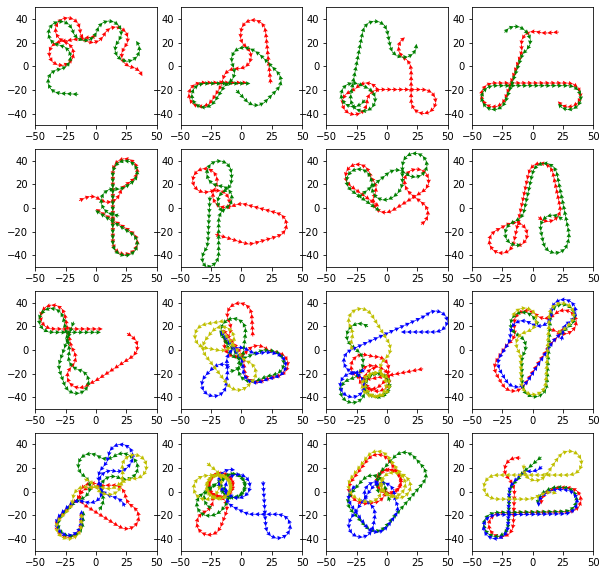

In [16]:
fig, axs = plt.subplots(4,4, figsize=(10,10))
colour_list = ["r", "g", "b", "y"]
counter = 40
for i in range(4):
    for j in range(4):
        for fish_id in range((~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1).sum()):
            #axs[i,j].plot(swarm_poses[counter,fish_id, :, 0], swarm_poses[counter,fish_id, :, 1], label=fish_id)
            a = swarm_poses[counter,fish_id, ::15, 0]
            b = swarm_poses[counter,fish_id, ::15, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', scale=1, headwidth=5, 
                           color = colour_list[fish_id])
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
        counter +=1
#plt.legend()
plt.show()

In [17]:
def predict_timeseries(start, edge_idx, steps):
    with torch.no_grad():
        model.eval()
        out_list = []
        out_list.append(start.numpy())
        x, edge_index = start.to(device), edge_idx.to(device)
        for step in range(steps):
            pred = model(x, edge_index)
            x = pred
            out_list.append(pred.cpu().numpy())
    out_list = np.array(out_list)
    return out_list

In [22]:
counter = 40
num_nodes = swarm_poses[counter][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)].shape[0]
list2 = []
list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
for i in range(num_nodes):
    list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
list2 = np.concatenate(list2)
start = torch.tensor(swarm_poses[counter,:, 0][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)],
                     dtype=torch.float)
edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
start, edge_index

(tensor([[  0.0278,  25.2252,   3.2855],
         [-14.4733, -23.7229,   3.0855]]),
 tensor([[0, 1],
         [1, 0]]))

In [23]:
predict_timeseries(start, edge_index, 5), predict_timeseries(start, edge_index, 5).shape

(array([[[  0.02778,  25.22518,   3.28552],
         [-14.4733 , -23.72289,   3.08553]],
 
        [[ -0.05351,  24.47386,   2.99111],
         [-14.17095, -22.93443,   2.86756]],
 
        [[ -0.15   ,  23.78654,   2.75816],
         [-13.87186, -22.14899,   2.69794]],
 
        [[ -0.25557,  23.15284,   2.57372],
         [-13.57487, -21.37236,   2.56582]],
 
        [[ -0.35744,  22.56491,   2.42884],
         [-13.2793 , -20.60873,   2.4628 ]],
 
        [[ -0.44755,  22.0161 ,   2.3158 ],
         [-12.98481, -19.86101,   2.38236]]], dtype=float32),
 (6, 2, 3))

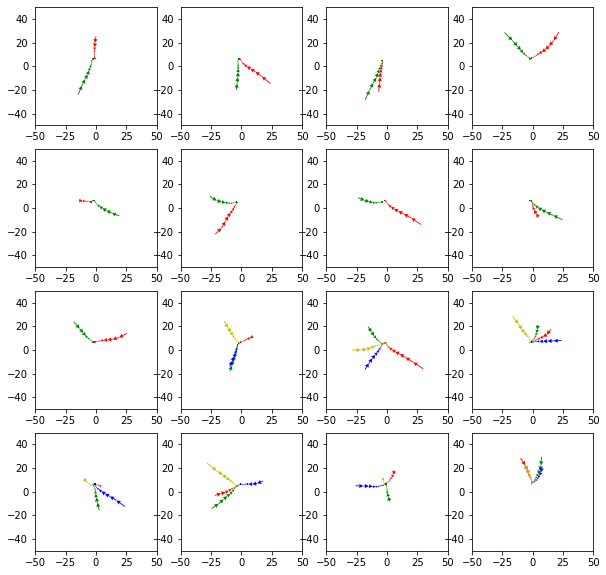

In [34]:
fig, axs = plt.subplots(4,4, figsize=(10,10))
counter = 40
for i in range(4):
    for j in range(4):
        num_nodes = swarm_poses[counter][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)].shape[0]
        list2 = []
        list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
        for k in range(num_nodes):
            list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
        list2 = np.concatenate(list2)
        start = torch.tensor(swarm_poses[counter,:, 0][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)],
                             dtype=torch.float)
        edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
        timeseries = predict_timeseries(start, edge_index, swarm_poses.shape[2]-1)
        for fish_id in range((~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1).sum()):
#             axs[i,j].plot(swarm_poses[counter,fish_id, :, 0], swarm_poses[counter,fish_id, :, 1], label=fish_id)
            a = timeseries[::10, fish_id, 0]
            b = timeseries[::10, fish_id, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', scale=1, headwidth=5, 
                           color = colour_list[fish_id])
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
        counter +=1
#plt.legend()
plt.show()

In [35]:
timeseries

array([[[-9.91347, 28.40997,  2.82126],
        [ 7.3559 , 29.44706,  3.7263 ],
        [ 7.93951, 21.39983,  4.0995 ],
        [-6.95815, 23.02831,  4.34017]],

       [[-9.37004, 27.65925,  2.5868 ],
        [ 7.42119, 28.46646,  3.38817],
        [ 7.84753, 20.66352,  3.69619],
        [-6.42864, 22.25197,  3.79994]],

       [[-8.84718, 26.97146,  2.40572],
        [ 7.48384, 27.56263,  3.1199 ],
        [ 7.75973, 19.99959,  3.37478],
        [-5.9669 , 21.5692 ,  3.38066]],

       ...,

       [[-0.86707,  6.69352,  2.01527],
        [-0.86707,  6.69352,  2.01527],
        [-0.86707,  6.69352,  2.01527],
        [-0.86707,  6.69352,  2.01527]],

       [[-0.86707,  6.69352,  2.01527],
        [-0.86707,  6.69352,  2.01527],
        [-0.86707,  6.69352,  2.01527],
        [-0.86707,  6.69352,  2.01527]],

       [[-0.86707,  6.69352,  2.01527],
        [-0.86707,  6.69352,  2.01527],
        [-0.86707,  6.69352,  2.01527],
        [-0.86707,  6.69352,  2.01527]]], dtype=float32)